In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:


import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim



In [0]:
import torchvision
#!wget  -P /content "https://storage.googleapis.com/kaggle-datasets/56851/109319/alien_vs_predator_thumbnails.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1566253849&Signature=OApXTGS6Q3LbFfRHg4K3WQzoVMY4qOr%2Bwp7cgwoF4FSlaJ9pgVtpC6jp96YU3%2BNhw4Ij1p6OSy2Fq3AU76dsRl8Rzr8VONsopclCRzPD05gKVlFg1QTzw%2B9L4xiVJlq3yhK2M9uuZG8R7LUCOQVRBsifaBNNMa2h%2FsdXo5hAXN2moAmci9xk%2Fmu%2Bar%2FURfzXlUG%2FuI8gax8VI4fcynJlhzlVo7jb81UOjytEPWbs2eDK55ubYIe3ephXL%2FKkGqUVZ6aWBjHs9%2FG9bO%2BLVBteJjoIU5QipWqj4wcZjgth7I0ZSTMQBTJufSzysZeTx8ApvId8SkxyzsN7amBoIZPm3A%3D%3D"
#!curl -O 'http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar'
!unzip alien_vs_predator_thumbnails.zip

Archive:  alien_vs_predator_thumbnails.zip
   creating: data/
   creating: data/validation/
   creating: data/train/
   creating: data/validation/predator/
  inflating: data/validation/predator/99.jpg  
  inflating: data/validation/predator/98.jpg  
  inflating: data/validation/predator/97.jpg  
  inflating: data/validation/predator/96.jpg  
  inflating: data/validation/predator/95.jpg  
  inflating: data/validation/predator/94.jpg  
  inflating: data/validation/predator/93.jpg  
  inflating: data/validation/predator/92.jpg  
  inflating: data/validation/predator/91.jpg  
  inflating: data/validation/predator/90.jpg  
  inflating: data/validation/predator/89.jpg  
  inflating: data/validation/predator/88.jpg  
  inflating: data/validation/predator/87.jpg  
  inflating: data/validation/predator/86.jpg  
  inflating: data/validation/predator/85.jpg  
  inflating: data/validation/predator/84.jpg  
  inflating: data/validation/predator/83.jpg  
  inflating: data/validation/predator/82.jpg 

In [0]:
input_path = "data/"

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [0]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [0]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.6669, acc: 0.6916
validation loss: 0.5009, acc: 0.8950
Epoch 2/3
----------
train loss: 0.4249, acc: 0.8775
validation loss: 0.3501, acc: 0.9150
Epoch 3/3
----------
train loss: 0.2959, acc: 0.8919
validation loss: 0.3064, acc: 0.8800


In [0]:
!mkdir models
!mkdir models/pytorch

In [0]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [0]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

pred_logits_tensor = model(validation_batch)
pred_logits_tensor



tensor([[ 1.3193, -1.1845],
        [ 0.3479, -0.1861],
        [-0.4180,  0.6544]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.9244064 , 0.07559361],
       [0.6304155 , 0.3695845 ],
       [0.2549311 , 0.74506885]], dtype=float32)

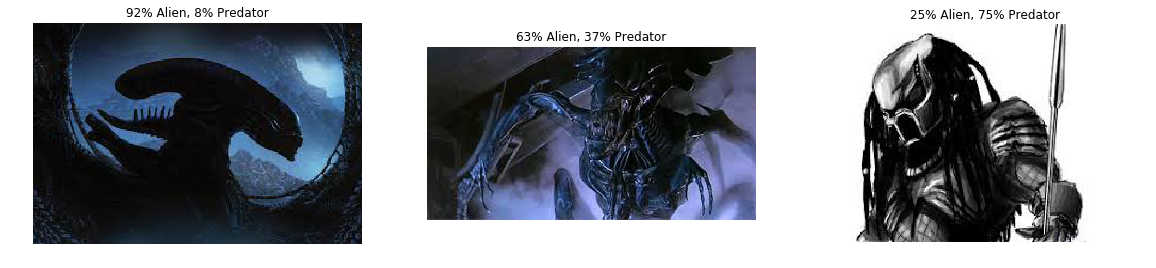

In [0]:


fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

